## MobileNet 
In this assignment Mobilenet architecture is used to train custom dataset. Developed APIs so as to load data, train, test and show results.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## Mount the google drive

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [4]:
!cp -rf '/content/drive/My Drive/EVA4Phase2/eva4_phase2_apis/models' .
!cp -rf '/content/drive/My Drive/EVA4Phase2/eva4_phase2_apis/data_loaders' .
!cp -rf '/content/drive/My Drive/EVA4Phase2/eva4_phase2_apis/data_transformations' .
!cp -rf '/content/drive/My Drive/EVA4Phase2/eva4_phase2_apis/utils' .


In [5]:
import sys
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
sys.path.append('/content/drive/My Drive/EVA4Phase2/eva4_phase2_apis/models/')  #Path for model
sys.path.append('/content/drive/My Drive/EVA4Phase2/eva4_phase2_apis/utils/') #Path for Graph Plottinng, Training & Test/Evaluation Logic
sys.path.append('/content/drive/My Drive/EVA4Phase2/eva4_phase2_apis/data_loaders/') #Path for DataLoad
sys.path.append('/content/drive/My Drive/EVA4Phase2/eva4_phase2_apis/data_transformations/') #Path for DataTransformation

## Import all the libraries

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from data_transformations.mobilenet_data_transformation import get_train_transform, get_test_transform
from data_loaders.mobilenet_data_loader import TrainImageDataset,TestImageDataset
from utils.train_test_utils import train, test
from utils.missclassified_util import plot_misclassified
#from utils.accuracy_utils import get_test_accuracy, get_accuracy_per_class

In [ ]:
!cp '/content/drive/My Drive/eva4_phase2_datasets/DronesBirdsDataset.zip' .


In [ ]:
!unzip -qq DronesBirdsDataset.zip


Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the custom Dataset
2. Use Mobilenet for transfer leaning
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data




 ## 1. Loading and normalizing Custom Dataset

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [7]:
cd /content/drive/My Drive/EVA4Phase2/

/content/drive/My Drive/EVA4Phase2


In [8]:
!ls

base_weights_lr_range_test.pth	DronesBirdsDataset.zip	test
data_loaders			eva4_phase2_apis	train
data_transformations		models			utils


In [9]:
import numpy as np
from torch.utils.data import Dataset,DataLoader
train_transform = get_train_transform()
test_transform = get_test_transform()
BATCH_SIZE=64

train_image_dataset = TrainImageDataset(root_dir='./train', transform = train_transform )
test_image_dataset = TestImageDataset(root_dir='./test', transform = test_transform )

train_dl = DataLoader(train_image_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
sample_train = next(iter(train_dl))
print(sample_train['X'].shape, sample_train['Y'].shape)

test_dl = DataLoader(test_image_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
sample_test = next(iter(test_dl))
print(sample_test['X'].shape, sample_test['Y'].shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])
torch.Size([64, 3, 224, 224]) torch.Size([64])


## Visualizing some of the images in train dataset



## 2. Define a Convolution Neural Network

I have defined the basic ResNet18 model and added dropout to it



In [10]:
!pip install torchsummary
import torch
from torchsummary import summary
from models.mobilenet_model import get_model
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = get_model(True)

model = model.to(device)
summary(model, input_size=(3, 224, 224))

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.01 with momentum 0.9.

## 4. Train the model

 I have used 30 epochs to train the model

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
PATH = '/content/drive/My Drive/EVA4Phase2/eva4_phase2_apis/model_mobilenet.pth'

In [ ]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
optimizer = optim.SGD(model.classifier[1].parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
best_test_accuracy = 0.0
EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dl, optimizer, epoch, train_losses,train_acc )
    test(model, device, test_dl, test_losses, test_acc)
    t_acc = test_acc[-1]
    if t_acc > best_test_accuracy:
        best_test_accuracy = t_acc
        torch.save(model.state_dict(), PATH)
        #model.to('cpu')
        #traced_model= torch.jit.trace(model, torch.rand(1,3,244,244))
        #traced_model.save(PATH)
        #compiled_model= torch.jit.script(model)
        #torch.jit.save(compiled_model,PATH)
    scheduler.step()

  0%|          | 0/125 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.6179730892181396 Batch_id=124 Accuracy=75.89: 100%|██████████| 125/125 [00:52<00:00,  2.40it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 1648/2000 (82.40%)

EPOCH: 1


Loss=0.49055296182632446 Batch_id=124 Accuracy=80.08: 100%|██████████| 125/125 [00:51<00:00,  2.45it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 1567/2000 (78.35%)

EPOCH: 2


Loss=0.6172369718551636 Batch_id=124 Accuracy=81.54: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 1566/2000 (78.30%)

EPOCH: 3


Loss=0.4754810929298401 Batch_id=124 Accuracy=81.22: 100%|██████████| 125/125 [00:50<00:00,  2.47it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 1524/2000 (76.20%)

EPOCH: 4


Loss=0.45034730434417725 Batch_id=124 Accuracy=81.38: 100%|██████████| 125/125 [00:50<00:00,  2.45it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0101, Accuracy: 1521/2000 (76.05%)

EPOCH: 5


Loss=0.49513113498687744 Batch_id=124 Accuracy=80.75: 100%|██████████| 125/125 [00:50<00:00,  2.48it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 1580/2000 (79.00%)

EPOCH: 6


Loss=0.5753405690193176 Batch_id=124 Accuracy=83.61: 100%|██████████| 125/125 [00:49<00:00,  2.50it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 1541/2000 (77.05%)

EPOCH: 7


Loss=0.36942553520202637 Batch_id=124 Accuracy=82.74: 100%|██████████| 125/125 [00:50<00:00,  2.48it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 1533/2000 (76.65%)

EPOCH: 8


Loss=0.5876733064651489 Batch_id=124 Accuracy=83.79: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 1557/2000 (77.85%)

EPOCH: 9


Loss=0.42044588923454285 Batch_id=124 Accuracy=83.47: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 1540/2000 (77.00%)

EPOCH: 10


Loss=0.4352028965950012 Batch_id=124 Accuracy=83.51: 100%|██████████| 125/125 [00:50<00:00,  2.47it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 1550/2000 (77.50%)

EPOCH: 11


Loss=0.558833122253418 Batch_id=124 Accuracy=82.90: 100%|██████████| 125/125 [00:50<00:00,  2.50it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 1562/2000 (78.10%)

EPOCH: 12


Loss=0.3733431100845337 Batch_id=124 Accuracy=83.74: 100%|██████████| 125/125 [00:50<00:00,  2.47it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 1562/2000 (78.10%)

EPOCH: 13


Loss=0.43649107217788696 Batch_id=124 Accuracy=83.30: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 1562/2000 (78.10%)

EPOCH: 14


Loss=0.3738235533237457 Batch_id=124 Accuracy=83.58: 100%|██████████| 125/125 [00:50<00:00,  2.48it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 1553/2000 (77.65%)

EPOCH: 15


Loss=0.29921621084213257 Batch_id=124 Accuracy=83.74: 100%|██████████| 125/125 [00:50<00:00,  2.50it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 1572/2000 (78.60%)

EPOCH: 16


Loss=0.4842725396156311 Batch_id=124 Accuracy=83.97: 100%|██████████| 125/125 [00:50<00:00,  2.48it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 1570/2000 (78.50%)

EPOCH: 17


Loss=0.41395846009254456 Batch_id=124 Accuracy=83.94: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 1580/2000 (79.00%)

EPOCH: 18


Loss=0.4599032700061798 Batch_id=124 Accuracy=83.81: 100%|██████████| 125/125 [00:49<00:00,  2.50it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 1566/2000 (78.30%)

EPOCH: 19


Loss=0.4175967872142792 Batch_id=124 Accuracy=84.08: 100%|██████████| 125/125 [00:50<00:00,  2.50it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 1569/2000 (78.45%)

EPOCH: 20


Loss=0.39516252279281616 Batch_id=124 Accuracy=83.30: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 1548/2000 (77.40%)

EPOCH: 21


Loss=0.30571311712265015 Batch_id=124 Accuracy=83.62: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 1554/2000 (77.70%)

EPOCH: 22


Loss=0.3508528172969818 Batch_id=124 Accuracy=83.54: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 1552/2000 (77.60%)

EPOCH: 23


Loss=0.6620977520942688 Batch_id=124 Accuracy=83.69: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]
  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 1548/2000 (77.40%)

EPOCH: 24


Loss=0.3481587767601013 Batch_id=124 Accuracy=83.81: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]



Test set: Average loss: 0.0089, Accuracy: 1561/2000 (78.05%)



## 4. Load the Best Model

In [12]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



In [ ]:
dataiter = iter(test_dl)
data = dataiter.next()

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
with torch.no_grad():
    images, labels = data['X'].to(device), data['Y'].to(device)
    outputs = model(images) 

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [15]:
classes = ( 'LargeQuadcopters', 'SmallQuadcopters', 'WingedDrones','FlyingBirds')

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(15)))

Predicted:  LargeQuadcopters FlyingBirds FlyingBirds WingedDrones FlyingBirds WingedDrones WingedDrones LargeQuadcopters LargeQuadcopters LargeQuadcopters SmallQuadcopters FlyingBirds FlyingBirds SmallQuadcopters FlyingBirds


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



## Test Accuracy

In [ ]:
correct = 0
with torch.no_grad():
    for test_data in test_dl:
        data, target = test_data['X'].to(device), test_data['Y'].to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
print("Test Accuracy: ", 100. * correct / len(test_dl.dataset))


Test Accuracy:  82.5


The accuracy 82.5 is far better than chance, which is 25% accuracy (randomly picking a class out of 4 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Accuracy
ii. Test Accuracy

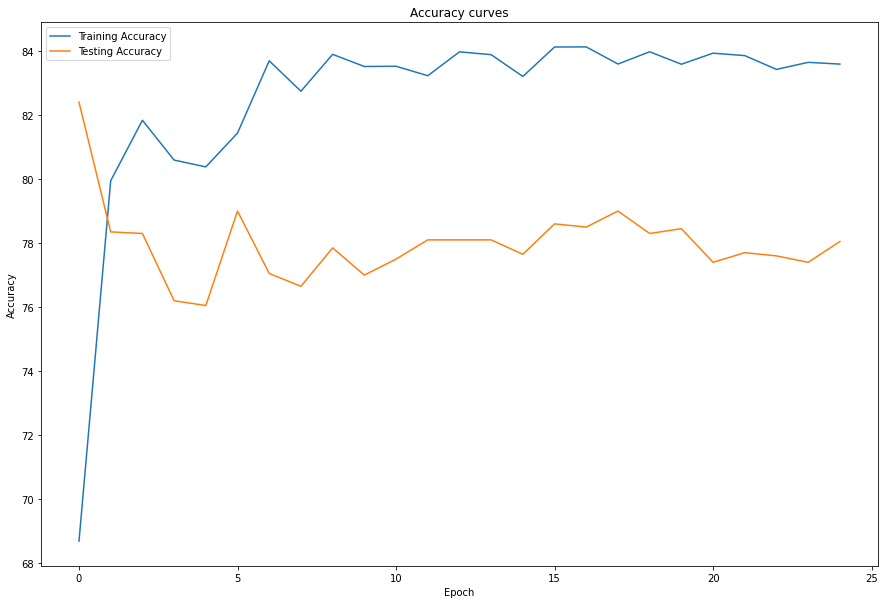

In [ ]:
from graphplot import plot_misclassified_images, plot_graph, plot_acc_loss_graph
plot_acc_loss_graph(train_acc,test_acc)

In [ ]:
sample_test = next(iter(test_dl))
print(sample_test['X'].shape, sample_test['Y'].shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [ ]:
plot_misclassified(model,test_dl,device,classes)

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([16, 3, 224, 224])
Oops! Error occurred.


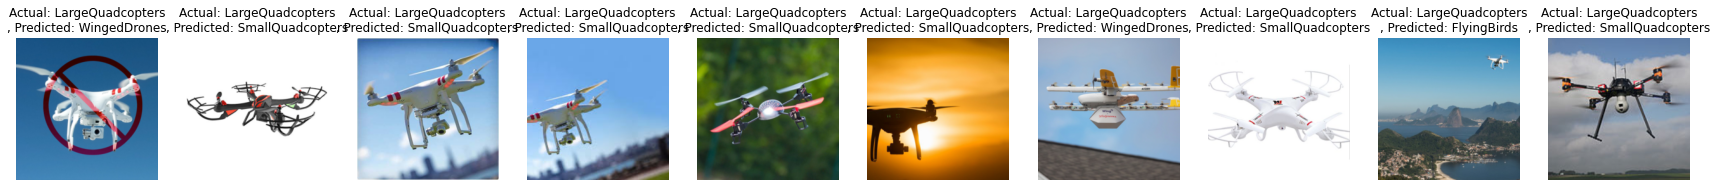

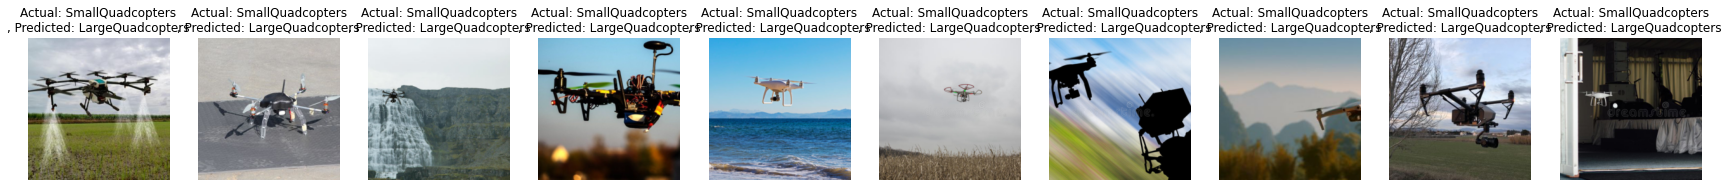

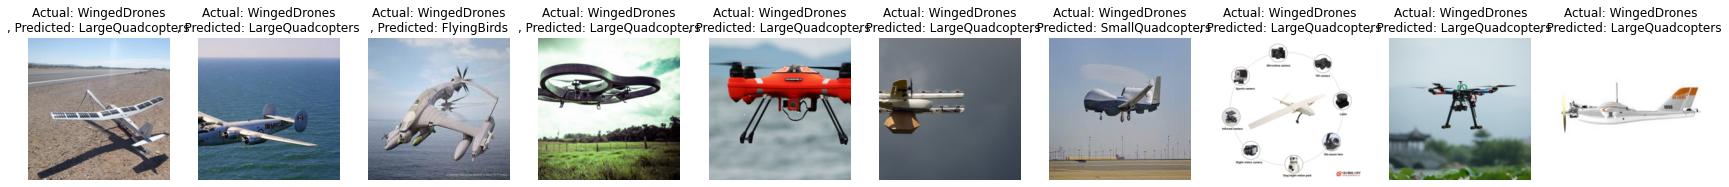

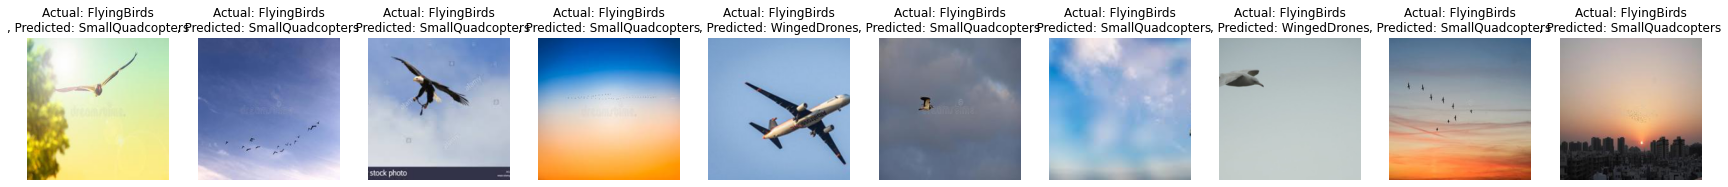

In [16]:
#!cp -rf '/content/drive/My Drive/eva4_phase2_apis/utils' .
#from utils.missclassified_util import plot_misclassified
plot_misclassified(model,test_dl,device,classes)

In [ ]:
MODEL_PATH = '/content/drive/My Drive/eva4_phase2_apis/model_mobilenet.pt'
model_cpu = model.to('cpu')
traced_model = torch.jit.trace(model_cpu, torch.randn(1,3, 224, 224))
traced_model.save(MODEL_PATH)

In [ ]:
!ls -l '/content/drive/My Drive/eva4_phase2_apis/model_mobilenet.pt'

-rw------- 1 root root 9441792 Aug  9 13:55 '/content/drive/My Drive/eva4_phase2_apis/model_mobilenet.pt'
